# Monetary Policy
This notebook looks at a monetary policy shocks when there is a government. Here, we replicate [link](https://github.com/shade-econ/nber-workshop-2022/blob/main/Tutorials/Tutorial%202%20Monetary%20Policy.ipynb)

In [1]:
#from ConsIndShockModel import IndShockConsumerType
from ConsIndShockModel_HANK import IndShockConsumerType
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict, UserProvidedSS
from sequence_jacobian import het, simple, create_model              # functions
from sequence_jacobian.blocks.block import Block
from sequence_jacobian.classes.result_dict import ResultDict
import matplotlib.pyplot as plt
import numpy as np
#import numba
import time

from scipy import optimize

# Case 1: Monetary Policy only

In [2]:
#Steady State values
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B
    
    return T


r_ss = 1.03 - 1
G_ss = 0
B_ss = 0 # this is lower than the tutorial by Straub et al. because need Higher MPC
A_ss = B_ss
Y_ss = 1.0
tau = 0.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)

print('T_ss: ' +str(T_ss))

Z_ss = Y_ss - T_ss

C_ss= Y_ss - G_ss
print('Z_ss: ' +str(Z_ss))

print('C_ss: ' +str(Y_ss - G_ss))

T_ss: 0.0
Z_ss: 1.0
C_ss: 1.0


In [24]:
#------------------------------------------------------------------------------------------------------
Dict = {
    # Parameters shared with the perfect foresight model
    "CRRA":2,                              # Coefficient of relative risk aversion
    "Rfree": 1+r_ss,                    # Interest factor on assets
    "DiscFac": 0.96,                      # Intertemporal discount factor
    "LivPrb" : [.99375],                   # Survival probability
    "PermGroFac" : [1.00],                 # Permanent income growth factor

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [.2],                   # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,    
    
    # HANK params
    "taxrate" : [tau], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Y_ss - T_ss],
    "wage": [1.0],
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.0,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0000,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0.0,                      # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)

    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.0001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 1500,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 300,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid

    # A few other parameters
    "BoroCnstArt" : -0.01, #-0.01,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : False,                   # Whether to calculate the value function during solution
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type 
    
    # Transition Matrix simulation parameters
    "mCount": 600,
    "mMax": 1000,
    "mMin": 0.0001,
    "mFac": 3,
}
T = 300 # Dimention of TxT Jacobian matrix

In [25]:
# to add taxes, labor and wage
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

Dict['TranShkMean_Func'] = [function]

# Get GE Steady stead values (TBD)

In [26]:
Agent = IndShockConsumerType(**Dict, verbose = False)

In [6]:
start = time.time()
Agent.compute_steady_state()
print('Seconds to compute steady state', time.time() - start)

Seconds to compute steady state 8.428131818771362


In [7]:
start = time.time()

CJACR, AJACR = Agent.calc_jacobian('Rfree',T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 8.394831895828247


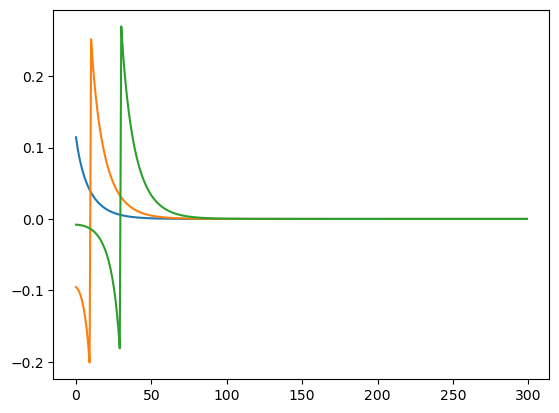

In [8]:
plt.plot(CJACR.T[0])
plt.plot(CJACR.T[10])
plt.plot(CJACR.T[30])
plt.show()

In [9]:
@sj.simple
def ex_post_rate(r_ante):
    r = r_ante(-1)
    return r

@sj.simple
def mkt_clearing_simple(A, Y, C):
    asset_mkt = A
    goods_mkt = C - Y
    return asset_mkt, goods_mkt

In [10]:
HARK_SteadyState_Dict = SteadyStateDict({"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss,  "r_ante": r_ss })
HARK_Jacobian_Dict = JacobianDict( { 'C' : {'r_ante' : CJACR} ,'A' : {'r_ante' : AJACR} } )

In [35]:
HARK_Jacobian_Dict['C']

{'r_ante': array([[ 1.14304610e-01, -3.57370332e-01, -3.01673057e-01, ...,
         -2.85705024e-12, -2.82753174e-12, -2.85705074e-12],
        [ 9.99612238e-02,  1.14304610e-01, -3.14259194e-01, ...,
         -2.47946236e-12, -2.50990974e-12, -2.47946335e-12],
        [ 8.82579729e-02,  9.99612237e-02,  1.51158568e-01, ...,
         -2.18755251e-12, -2.15866797e-12, -2.18755365e-12],
        ...,
        [ 2.46691556e-09,  2.51053666e-13,  3.85200992e-13, ...,
          2.69819800e-01, -1.80919210e-01, -1.51594278e-01],
        [ 2.46691556e-09,  2.30747987e-13,  3.57234771e-13, ...,
          2.37545605e-01,  2.69819800e-01, -1.80919210e-01],
        [ 2.46469511e-09,  2.12218470e-13,  3.31613702e-13, ...,
          2.10502990e-01,  2.37545605e-01,  2.69819800e-01]])}

In [12]:
HARK_HANK = create_model([HARK_Jacobian_Dict, ex_post_rate, mkt_clearing_simple], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['r_ante']

In [31]:
# Find the linear impulse responses to an "r" shock
dr = -0.01 * 0.7 ** np.arange(T)
shocks = {'r_ante': dr}

In [32]:
J_ex_post_rate = ex_post_rate.jacobian(HARK_SteadyState_Dict, inputs=['r_ante'])

In [33]:
J_ex_post_rate['r']

{'r_ante': SimpleSparse({(-1, 0): 1.000})}

In [34]:
irf = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, ['Y'], ['asset_mkt'], shocks) #{'r_ante': dr})
tutil.figure_1(irf, HARK_SteadyState_Dict, dr)

LinAlgError: Singular matrix

# Case 2: With Fiscal Policy

In [36]:
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B
    Z = Y - T
    
    deficit = G - T
    
    return T, Z, deficit

In [37]:
r_ss = 1.03 - 1
G_ss = 0
B_ss = 0 # this is lower than the tutorial by Straub et al. because need Higher MPC
A_ss = B_ss
Y_ss = 1.0
tau = 0.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)

print('T_ss: ' +str(T_ss))

Z_ss = Y_ss - T_ss

C_ss= Y_ss - G_ss
print('Z_ss: ' +str(Z_ss))

print('C_ss: ' +str(Y_ss - G_ss))

T_ss: 0.0
Z_ss: 1.0
C_ss: 1.0


## Steady State GE

In [38]:
Agent_Case2 = IndShockConsumerType(**Dict, verbose = False)

In [39]:
start = time.time()
Agent_Case2.compute_steady_state()
print('Seconds to compute steady state', time.time() - start)

Seconds to compute steady state 3.1303212642669678


In [41]:
start = time.time()

CJACR_Case2, AJACR_Case2 = Agent_Case2.calc_jacobian('Rfree',T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 8.56761121749878


In [42]:
HARK_SteadyState_Dict_Case2 = SteadyStateDict({"G": 1.0, "asset_mkt":0.0, "C": C_ss, "r": r_ss, "Y": Y_ss, "B":B_ss, "G":G_ss, "A": A_ss,  "r_ante": r_ss })
HARK_Jacobian_Dict_Case2 = JacobianDict( { 'C' : {'r_ante' : CJACR_Case2} ,'A' : {'r_ante' : AJACR_Case2} } )

In [43]:
HARK_HANK_Case2 = create_model([HARK_Jacobian_Dict, fiscal, ex_post_rate, mkt_clearing_simple], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['r_ante']

In [44]:
irf_Case2 = HARK_HANK_Case2.solve_impulse_linear(HARK_SteadyState_Dict_Case2, ['Y'], ['asset_mkt'], shocks) #{'r_ante': dr})
tutil.figure_1(irf_Case2, HARK_SteadyState_Dict_Case2, dr)

LinAlgError: Singular matrix